The MTA Model is used to specify the role of indivudal touch points in a customers journey from start till conversion. It can help marketing professionals and product managers better understand which element of their marketing campaigns are working the best. It can be used in tandom with Marketing Mix Models and other similar models


The process is broken into 3 parts.

1. Data Processing
2. General EDA
3. Attribution Modeling.

We will look at 4 types of attribution models,
- **First Touch Conversion**: The conversion is attributed to the first channel the customer interacts with.
- **Last Touch Conversion**: A user's conversion is attributed to the last channel they enteract with
- **Linear Touch Conversions**: All channels are given equal weight for conversion.
- **Markov chains**: A probabilistic model that represents the buyer's journey as a graph, with the nodes representing different channels/touchpoints, and the connecting lines being observed transitions between them. The number of times buyers have transitioned between two states is converted into a probability, which can then be used to measure the importance of each channel and the most likely channel paths to success.





In [1]:
%%capture
!pip install --upgrade pip
!pip install ChannelAttribution

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import plotly.express as px

from ChannelAttribution import *
import plotly.io as pio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

In [2]:
#Importing the data
df = pd.read_csv('/content/attribution data.csv')
df['time'] = pd.to_datetime(df['time'])
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search


Simple EDA

Lets see conversions for different chanels per time

In [3]:
#Plotting conversions over time by channel

conversions = df.loc[df['conversion'] == 1]
conversions['time'] = conversions['time'].dt.date
conversions = conversions[conversions['time'] < pd.to_datetime("2018-7-30").date()]

conversions.drop(columns = ['cookie', 'interaction'], inplace = True)
conversions = conversions.groupby(['time','channel'], as_index=False).sum()

fig = px.line(conversions, x='time', y='conversion', color='channel')

fig.update_layout(title='Channel Conversions over Time',
                   xaxis_title='Conversions',
                   yaxis_title='Date')
fig.show()

Data Pre-processing.

Before moving onto attribution models, we must get the 'path' for every individual user, represented by cookie in this example. We want to know what were the channels they interacted with and if they converted or not.

In [4]:
#Creating the path order for when users interact with different channels (this is equivalent to SQL window functions)

df['path_order'] = df.sort_values(['time']).groupby(['cookie']).cumcount() + 1
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,path_order
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,1
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,3
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,4
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,1


The code above sorts the df by time and groups by cookies. the cumcount + 1 numbers the path orders. so now we have path orders, in simpler words, we know in which order each cookie interacts with a channel

In [5]:
#Aggregating the channels a user interacted with into a single row
df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns = {'channel': 'path'})
df_paths.head()

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On..."
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S..."
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S..."
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


This step was essentail for building a multi touch attribution model because understanding the order in which the users interact with our channels is crucial.

In [6]:
#Looking at the last interaction to see if it led to a user converting

df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_value']]

df_last_interaction.head()

,cookie,conversion,conversion_value
3,00000FkCnDfDDf0iC97iC703B,0,0.0
9,0000nACkD9nFkBBDECD3ki00E,0,0.0
14,0003EfE37E93D0BC03iBhBBhF,0,0.0
15,00073CFE3FoFCn70fBhB3kfon,0,0.0
16,00079hhBkDF3k3kDkiFi9EFAD,0,0.0


here we keep only the last occurance of each cookie i.e. the last channel they interacted with along with the conversion and conversion value from that. aim is to see if last channel interaction yeilds in a conversion.

In [7]:
#Concatinating with the dataframes of user path's

df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On...",0,0.0
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,0.0


In [8]:
print('Total conversions: {}'.format(sum(df.conversion)))
print('Total conversion rate: {}%'.format(round(sum(df.conversion) / len(df)*100)))
print('Total value of conversions: ${}'.format(round(sum(df.conversion_value))))
print('Average conversion value: ${}'.format(round(sum(df.conversion_value) / sum(df.conversion))))

Total conversions: 17639
Total conversion rate: 3%
Total value of conversions: $110231
Average conversion value: $6


In [9]:
#We will create a variable ‘path’ in the specific formatrequired by the Attribution Model where the ordered channels a user interacts with are delimited by'>'

def listToString(df):
    str1 = ""
    for i in df['path']:
        str1 += i + ' > '
    return str1[:-3]

df_paths['path'] = df_paths.apply(listToString, axis=1)
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,Instagram > Online Display > Online Display > ...,0,0.0
1,0000nACkD9nFkBBDECD3ki00E,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
2,0003EfE37E93D0BC03iBhBBhF,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
3,00073CFE3FoFCn70fBhB3kfon,Instagram,0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0,0.0


In [10]:
#Removing the user's cookie and grouping by the path to see the how many times a specific combination of channels led to a conversion or null outcome
df_paths.drop(columns = 'cookie', inplace = True)
df_paths['null'] = np.where(df_paths['conversion'] == 0,1,0)

attribution_df = df_paths.groupby(['path'], as_index = False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", "null": "total_null", "conversion_value": "total_conversion_value"}, inplace = True)
attribution_df.sample(10)

,path,total_conversions,total_conversion_value,total_null
5438,Instagram > Instagram > Instagram > Facebook >...,0,0.0,1
2428,Facebook > Instagram > Facebook > Facebook > O...,0,0.0,1
7750,Online Video > Facebook > Online Video > Onlin...,0,0.0,1
8792,Online Video > Online Video > Online Video > O...,0,0.0,1
3984,Facebook > Paid Search > Paid Search > Paid Se...,0,0.0,1
583,Facebook > Facebook > Facebook > Facebook > In...,0,0.0,1
8026,Online Video > Online Video > Facebook > Insta...,0,0.0,1
6930,Online Display > Online Display > Online Displ...,0,0.0,1
4196,Instagram > Facebook > Facebook > Facebook > F...,0,0.0,1
2558,Facebook > Instagram > Facebook > Instagram > ...,0,0.0,1


here is isolate each type of channel mix and see what their conversions, conversion_values etc. are.

Next we move to Attribution Modeling

In [11]:
#Now, we will use the ChannelAttribution package to create the attribution models

#Heuristic models
H = heuristic_models(attribution_df, 'path', 'total_conversions', var_value='total_conversion_value')

#Markov Models
M = markov_model(attribution_df, 'path', 'total_conversions', var_value='total_conversion_value')



*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 1.58% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (48) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


In [12]:
R = pd.merge(H, M, on = 'channel_name', how = 'inner')
R1=R[["channel_name","first_touch_conversions","last_touch_conversions", "linear_touch_conversions","total_conversions"]]

R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R1=pd.melt(R1, id_vars="channel_name")

data = [dict(type = "histogram", histfunc="sum",x = R1.channel_name, y = R1.value,
             transforms = [dict(type = "groupby", groups = R1.variable,)],)]

fig = dict({"data":data})
pio.show(fig,validate=False)



The part each channel plays according to all 4 of our attribution models


In [13]:
R2=R[["channel_name","first_touch_value","last_touch_value",\
"linear_touch_value","total_conversion_value"]]
R2.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R2=pd.melt(R2, id_vars="channel_name")
data = [dict(type = "histogram", histfunc="sum", x = R2.channel_name, y = R2.value,
             transforms = [dict(type = "groupby",groups = R2.variable,)],)]

fig = dict({"data":data})
pio.show(fig,validate=False)

same in terms of value

In [14]:
transition_matrix = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


In [15]:
matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)

<ipython-input-15-ce9ba9d4219b>:2: FutureWarning:

The provided callable <function sum at 0x7ff216ecae60> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, '(conversion)'),
  Text(1.5, 0, '(null)'),
  Text(2.5, 0, 'Facebook'),
  Text(3.5, 0, 'Instagram'),
  Text(4.5, 0, 'Online Display'),
  Text(5.5, 0, 'Online Video'),
  Text(6.5, 0, 'Paid Search')])

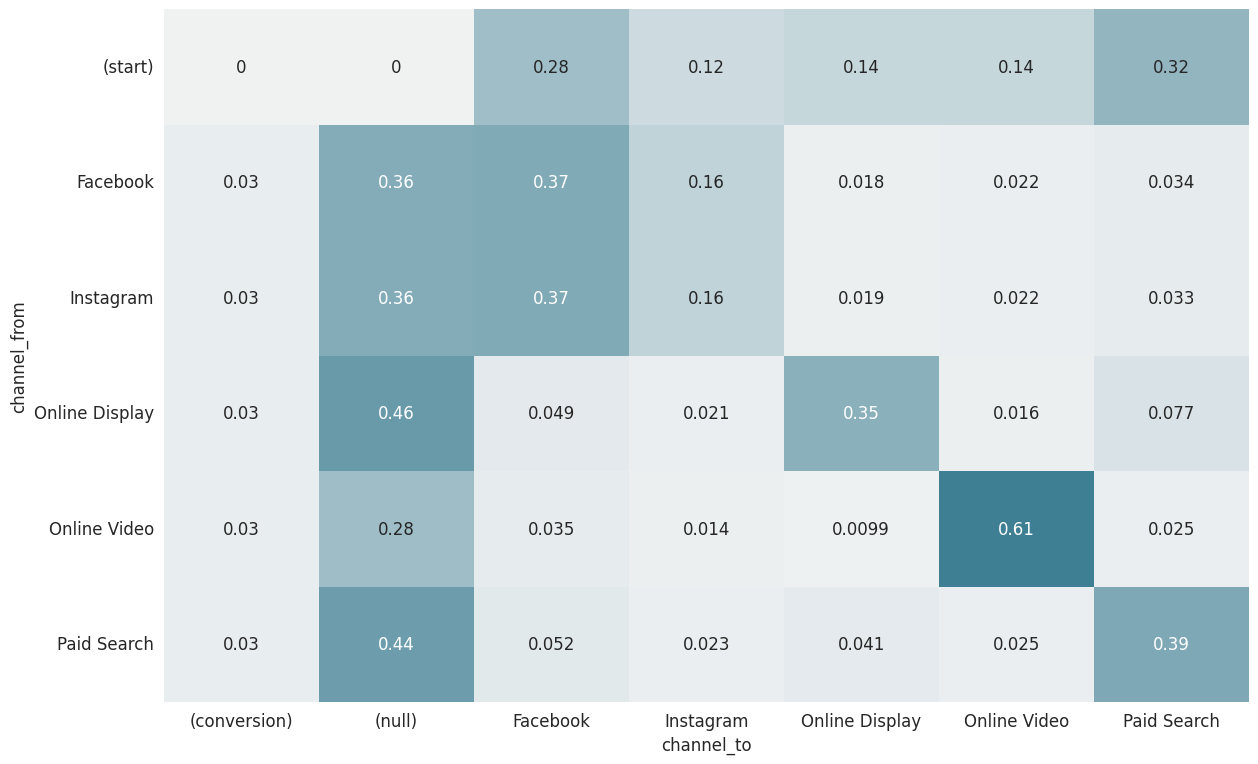

In [16]:
#Heat map for transition probabilities in the data set
fig = plt.figure(figsize = (14,9))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, center = 0,\
            annot_kws={'size':12}, cbar=False)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)